In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data"
!rm -f data
!ln -s "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data" data

Mounted at /content/drive


In [2]:
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

In [3]:
review_df = pd.read_csv('data/review.csv')
val_df = pd.read_csv("data/validation.csv")
pred_df = pd.read_csv('data/prediction.csv')
print("Size of training set:", [len(review_df)])
review_ratings = review_df['Star'].values
print("Size of validation set:", [len(val_df)])
val_ratings = val_df['Star'].values
print("Size of prediction set:", [len(pred_df)])

Size of training set: [52697]
Size of validation set: [6596]
Size of prediction set: [6597]


In [4]:
import json

with open('data/product.json') as f:
    products = json.load(f)

In [5]:
print("num of data = ", len(products))

detail_col_name = []
columns_name = []
for product in products:
  columns_name += list(product.keys())
columns_name = list(set(columns_name))
columns_name = list([col for col in products[0].keys() if col != "details"])

for product in products:
  detail_col_name += list(product["details"].keys())
detail_col_name = list(set(detail_col_name))

print(columns_name)
print(detail_col_name)
print("num of unique columns = ",len(columns_name), "\nnum of unique columns in details section = ",len(detail_col_name))


num of data =  6734
['category', 'tech1', 'description', 'fit', 'title', 'tech2', 'brand', 'feature', 'rank', 'main_cat', 'similar_item', 'date', 'price', 'imageURL', 'imageURLHighRes', 'ProductID']
['ISBN-13:', 'Print Length:', 'ASIN:', 'Publisher:', 'Simultaneous Device Usage:', 'ISBN-10:', 'Word Wise:', 'Release Date:', 'Page Numbers Source ISBN:', 'File Size:', 'Language:', 'Publication Date:', 'Lending:']
num of unique columns =  16 
num of unique columns in details section =  13


In [6]:
#find empty columns
column_empty_count = {col:0 for col in columns_name+detail_col_name}
column_count = {col:0 for col in columns_name+detail_col_name}
for col in columns_name:
  for product in products:
    value = product[col]
    column_count[col] += 1
    if value in [None, '', {},[]]:
      column_empty_count[col] += 1
for col in detail_col_name:
  for product in products:
    try:
      value = product["details"][col]
      column_count[col] += 1
      if value in [None, '', {}]:
        column_empty_count[col] += 1
    except KeyError:
      #some products does not have certain columns, thus we need to avoid key error
      continue


In [7]:
print(column_empty_count)
print(column_count)

{'category': 0, 'tech1': 6734, 'description': 6734, 'fit': 6734, 'title': 30, 'tech2': 6734, 'brand': 0, 'feature': 6734, 'rank': 14, 'main_cat': 0, 'similar_item': 6734, 'date': 6734, 'price': 6733, 'imageURL': 6734, 'imageURLHighRes': 6734, 'ProductID': 0, 'ISBN-13:': 0, 'Print Length:': 0, 'ASIN:': 0, 'Publisher:': 0, 'Simultaneous Device Usage:': 0, 'ISBN-10:': 0, 'Word Wise:': 0, 'Release Date:': 0, 'Page Numbers Source ISBN:': 0, 'File Size:': 0, 'Language:': 0, 'Publication Date:': 0, 'Lending:': 0}
{'category': 6734, 'tech1': 6734, 'description': 6734, 'fit': 6734, 'title': 6734, 'tech2': 6734, 'brand': 6734, 'feature': 6734, 'rank': 6734, 'main_cat': 6734, 'similar_item': 6734, 'date': 6734, 'price': 6734, 'imageURL': 6734, 'imageURLHighRes': 6734, 'ProductID': 6734, 'ISBN-13:': 21, 'Print Length:': 6677, 'ASIN:': 6734, 'Publisher:': 4495, 'Simultaneous Device Usage:': 3947, 'ISBN-10:': 21, 'Word Wise:': 6711, 'Release Date:': 23, 'Page Numbers Source ISBN:': 748, 'File Size:'

In [8]:
#find out the empty columns:
print([col for col in column_empty_count if column_empty_count[col] == len(products)])

['tech1', 'description', 'fit', 'tech2', 'feature', 'similar_item', 'date', 'imageURL', 'imageURLHighRes']


In [9]:
#find out columns that are not in every product:
print({col:column_count[col] for col in column_count if column_count[col] != len(products)})

{'ISBN-13:': 21, 'Print Length:': 6677, 'Publisher:': 4495, 'Simultaneous Device Usage:': 3947, 'ISBN-10:': 21, 'Word Wise:': 6711, 'Release Date:': 23, 'Page Numbers Source ISBN:': 748, 'Publication Date:': 6711, 'Lending:': 6711}


###Preprocessing
this part preprocess the the json file by convert rank to integers, expand the details category in details column and delete empty columns such as tech1, tech2, etc.

In [10]:
#Extract num value from rank ('rank': '88,963 Paid in Kindle Store (' -> 'rank': 88,963)
for product in products:
    rank_value = product['rank']
    if isinstance(rank_value, str):
        # Extracting the numerical part of the rank string
        rank_num = int(rank_value.split()[0].replace(',', ''))
        product['rank'] = rank_num

In [11]:
for product in products:
    rank_value = product.get('rank')
    if isinstance(rank_value, str):
        # Extracting the numerical part of the rank string and converting to integer
        rank_num = ''.join(filter(str.isdigit, rank_value))
        if rank_num:
            product['rank'] = int(rank_num)

    if not isinstance(product['rank'], int):
        print("Non-numeric value found in 'rank':", product['rank'])
        product['rank'] = 0

Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []


In [12]:
for product in products:
    details = product.get('details', {})

    #Extract num value from details.File Size ('File Size:': '2199 KB' -> 'file_size': 2199)
    file_size_str = details.pop('File Size:', None)
    if file_size_str:
        # Extracting the numerical part of 'File Size'
        file_size_num = int(''.join(filter(str.isdigit, file_size_str)))
        # Adding 'File Size' as a top-level key in the product dictionary
        product['file_size'] = file_size_num

    #Extract num value from details. ('Print Length:': '314 pages' -> 'print_length': 314)
    print_len_str = details.pop('Print Length:', None)
    if print_len_str:
        # Extracting the numerical part of 'Print Length:'
        file_size_num = int(''.join(filter(str.isdigit, print_len_str)))
        # Adding 'Print Length:' as a top-level key in the product dictionary
        product['print_length'] = file_size_num

    #Extract num value from details. ('Publisher:':'Del Rey (September 30, 2003)' -> 'publisher':'Del Rey')
    publisher_str = details.get('Publisher:', '')
    if publisher_str:
        # Remove the date part, if present
        publisher_clean = publisher_str.split('(')[0].strip()
        product['publisher'] = publisher_clean

    product['word_wise'] = details.get('Word Wise:', '')
    product['lending'] = details.get('Lending:', '')
    product['language'] = details.get('Language:', '')

# Assuming delete empty columns
for product in products:
  del product['tech1']
  del product['tech2']
  del product['description']
  del product['fit']
  del product['feature']
  del product['similar_item']
  del product['date']
  del product['imageURL']
  del product['imageURLHighRes']
  del product['details']

##Product Json file Visualisation

In [13]:
product_df = pd.DataFrame.from_records(products)
product_df.head()

,category,title,brand,rank,main_cat,price,ProductID,file_size,print_length,publisher,word_wise,lending,language
0,"[Kindle Store, Kindle eBooks, Science Fiction ...",,Visit Amazon's Elizabeth Moon Page,88963,Buy a Kindle,,B000FBJBA4,2199,314.0,Del Rey,Enabled,Not Enabled,English
1,"[Kindle Store, Kindle eBooks, Politics & Socia...",,Visit Amazon's Karl Marx Page,1358073,Buy a Kindle,,B000FC27TA,142,160.0,Bantam Classics; Reissue edition,Enabled,Not Enabled,English
2,"[Kindle Store, Kindle eBooks, Romance]",,Visit Amazon's Allison Brennan Page,94006,Buy a Kindle,,B000FCKPG2,739,416.0,Ballantine Books,Enabled,Not Enabled,English
3,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,Visit Amazon's Lynsay Sands Page,31652,Buy a Kindle,,B000GCFWXW,1011,384.0,HarperCollins e-books,Enabled,Not Enabled,English
4,"[Kindle Store, Kindle eBooks, Romance]",,Visit Amazon's Fern Michaels Page,1031468,Buy a Kindle,,B000JMKRTI,519,320.0,Zebra,Enabled,Not Enabled,English


In [14]:
product_df.columns

Index(['category', 'title', 'brand', 'rank', 'main_cat', 'price', 'ProductID',
       'file_size', 'print_length', 'publisher', 'word_wise', 'lending',
       'language'],
      dtype='object')

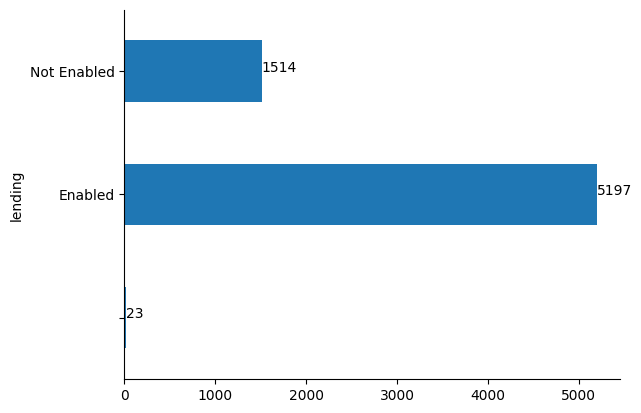

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

# Group by 'lending' and get the size of each group
grouped_data = product_df.groupby('lending').size()

# Create the horizontal bar plot
ax = grouped_data.plot(kind='barh')

# Hide top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with its value
for i, v in enumerate(grouped_data):
    ax.text(v + 0.2, i, str(v), color='black', ha='left')

plt.show()

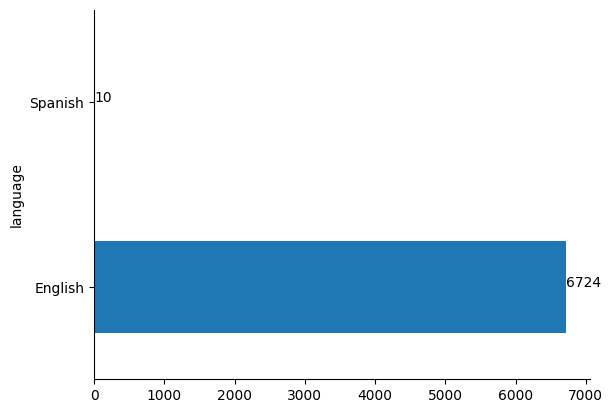

In [16]:
# @title language

from matplotlib import pyplot as plt
import seaborn as sns

# Group by 'lending' and get the size of each group
grouped_data = product_df.groupby('language').size()

# Create the horizontal bar plot
ax = grouped_data.plot(kind='barh')

# Hide top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with its value
for i, v in enumerate(grouped_data):
    ax.text(v + 0.2, i, str(v), color='black', ha='left')

plt.show()

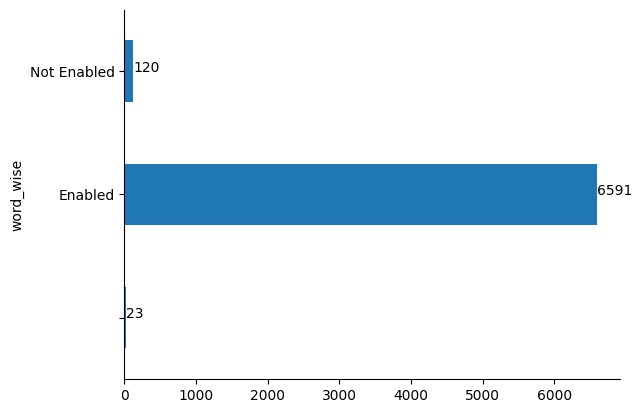

In [17]:
# @title word_wise
from matplotlib import pyplot as plt
import seaborn as sns

# Group by 'lending' and get the size of each group
grouped_data = product_df.groupby('word_wise').size()

# Create the horizontal bar plot
ax = grouped_data.plot(kind='barh')

# Hide top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with its value
for i, v in enumerate(grouped_data):
    ax.text(v + 0.2, i, str(v), color='black', ha='left')
plt.show()

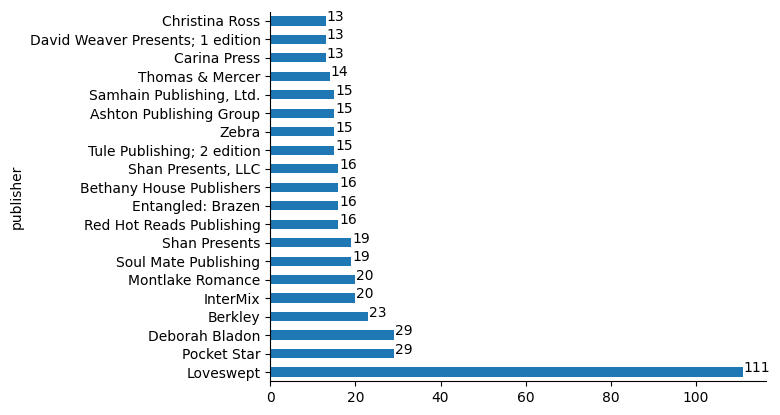

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

# Group by 'product_publisher' and get the size of each group
grouped_data = product_df['publisher'].value_counts().nlargest(20)

# Create the horizontal bar plot
ax = grouped_data.plot(kind='barh')

# Hide top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with its value
for i, v in enumerate(grouped_data):
    ax.text(v + 0.2, i, str(v), color='black', ha='left')

plt.show()

In [19]:
# @title rank
#rank is the number of books sold
print("min: ",min(product_df["rank"]))
print("max: ",max(product_df["rank"]))
print("mean: ",np.mean(product_df["rank"]))
print("SD: ", np.std(product_df["rank"]))

min:  0
max:  5200863
mean:  265330.40243540244
SD:  347614.5580652964


###Data Visualisation on Training Set

In [20]:
review_df.head()

,ReviewerID,ProductID,Text,Summary,Star
0,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0
1,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0
2,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0
3,ACVNKHUOX3QWU,B000GCFWXW,I liked this story although its probably not o...,Different,4.0
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0


class imbalance observed

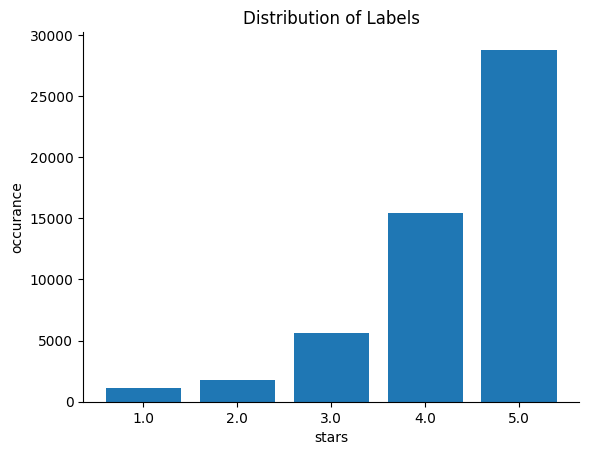

In [21]:
count_dict = dict(Counter(review_df["Star"]))
count_dict = dict(sorted(count_dict.items()))
plt.bar(range(len(count_dict)), list(count_dict.values()), tick_label=list(count_dict.keys()))
plt.title("Distribution of Labels")
plt.xlabel("stars")
plt.ylabel("occurance")
plt.gca().spines[['top', 'right',]].set_visible(False)

In [29]:
# Get the unique set of all user ids and set of all business ids in train set
user_set = set(review_df.ReviewerID.unique())
business_set = set(review_df.ProductID.unique())

# Build user vocabulary
user_vocab = dict(zip(user_set, range(1, len(user_set) + 1)))

# Reserve the first row of the embedding matrix for users unseen in the training set
user_vocab['unk'] = 0
n_users = len(user_vocab)

# Build business vocabulary
business_vocab = dict(zip(business_set, range(1, len(business_set) + 1)))
# Reserve the first row of the embedding matrix for businesses unseen in the training set
business_vocab['unk'] = 0
n_items = len(business_vocab)
review_df.ReviewerID = review_df.ReviewerID.apply(lambda x: user_vocab[x]).values
review_df.ProductID = review_df.ProductID.apply(lambda x: business_vocab[x]).values

In [30]:
user_item_matrix = review_df.pivot_table(index='ReviewerID', columns='ProductID', values='Star', fill_value=0)

In [31]:
total_possible_values = user_item_matrix.shape[0] * user_item_matrix.shape[1]
num_missing_values = user_item_matrix.isnull().sum().sum()
sparsity = num_missing_values / total_possible_values
print(f"Sparsity of the user-item interaction matrix: {sparsity:.2%}")

Sparsity of the user-item interaction matrix: 0.00%
